In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator(freq=[1, 2, 3, 4],
                                 D_crit_factor=[0.9, 0.95, 1, 1.05, 1.1])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [365]:
### --- Set empirical parameters --- ###

#network properties size
N = 6000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [366]:
#Set tasks

R = 2
gamma = 0.99
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance_block_haar(R=R,
                                                                                            gamma=gamma,
                                                                                            report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
theta = np.pi/6
sigma_mn_all[:,:,0] = gamma * np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

0


In [412]:
N_W_samples = 1
C_emp_avg = 0
X_emp_avg = 0

D_changed = D.copy()
D_changed[0] = 5.3

#lags window
dt = 0.05
T_window_emp = 80
dT_emp = 0.5
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

for i_W_sample in range(N_W_samples):
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
    T_sim = 2000
    dt = 0.05
    
    ### --- Estimate C empirically --- ###
    
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    x = torch.from_numpy(x).type(torch.FloatTensor).to(0)
    C_emp_unit = compute_lagged_xcov(r[:,None,:], r[:,None,:], lags_emp, dt_save=dt)
    C_emp = C_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    C_emp = upsample_array(C_emp, int(dT_emp/dt))
    C_emp = np.concatenate([C_emp, np.array([C_emp[-1]]), C_emp[1:][::-1]])
    X_emp_unit = compute_lagged_xcov(x[:,None,:], x[:,None,:], lags_emp, dt_save=dt)
    X_emp = X_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    X_emp = upsample_array(X_emp, int(dT_emp/dt))
    X_emp = np.concatenate([X_emp, np.array([X_emp[-1]]), X_emp[1:][::-1]])
    lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
    
    C_emp_avg += C_emp / N_W_samples
    X_emp_avg += X_emp / N_W_samples

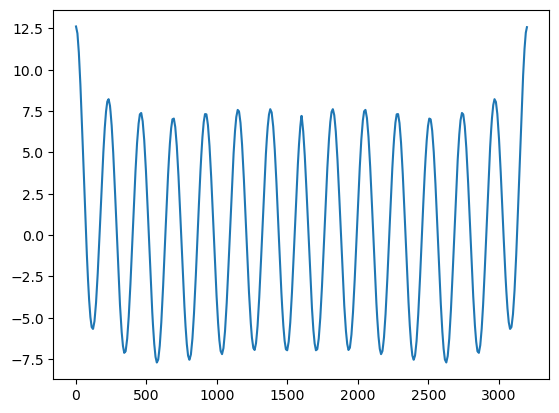

In [413]:
plt.plot(X_emp_avg)

5.1


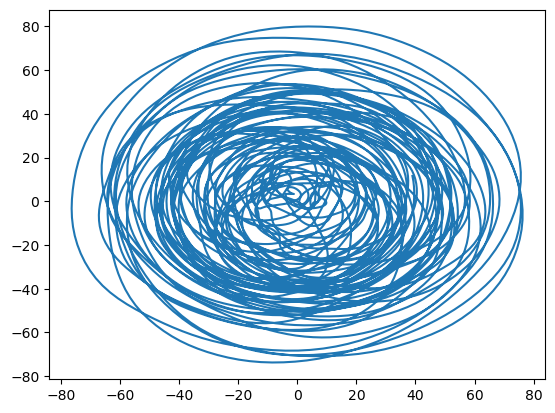

In [341]:
Z_mags = []
D_values = [5.1]
for D_ in D_values:
    print(D_)
    D_changed = D.copy()
    D_changed[0] = D_
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
    T_sim = 1000
    dt = 0.1

    ### --- Estimate C empirically --- ###

    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    x = torch.from_numpy(x).type(torch.FloatTensor).to(0)
    Z = D_changed[0]*np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r.cpu().numpy())
    plt.plot(Z[0,:,0], Z[0,:,1])
    Z_mag = np.sqrt(Z[0,:,0]**2 + Z[0,:,1]**2)
    Z_mags.append(np.amax(Z_mag))

In [342]:
np.mean(x.cpu().numpy()**2)
pprime = phi_prime_torch(x).cpu().numpy().mean()
pprime = compute_phi_prime_avg(np.mean(x.cpu().numpy()**2))

In [343]:
pprime * D_ * gamma * np.cos(np.pi/6)

0.9902418673528384

In [344]:
np.mean(x.cpu().numpy()**2)

11.776175

In [178]:
compute_phi_prime_avg(d0 + A**2/(1+omega0**2)) * D0 * gamma * np.cos(theta0)

9

In [313]:
(1 + np.tan(np.pi/6)**2)

1.3333333333333333

In [345]:
np.mean(x.cpu().numpy()**2) - (np.amax(Z[0,:,0]/np.sqrt(N)))**2 / (1 + np.tan(np.pi/6)**2)

11.230792346124378

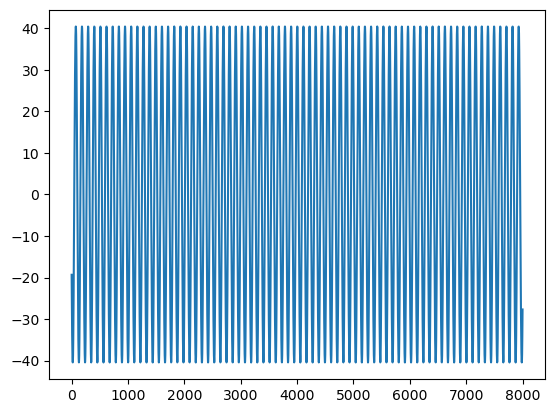

In [246]:
plt.plot(x[:,4].cpu().numpy())

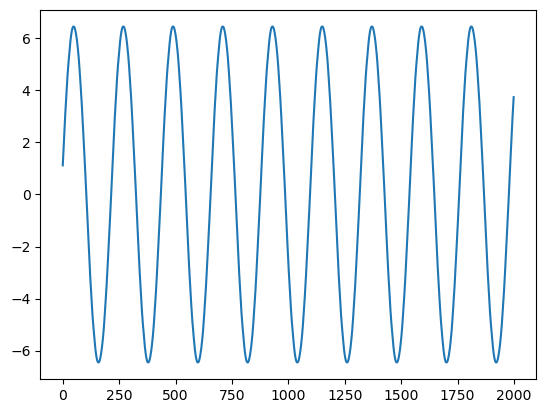

In [148]:
plt.plot(Z[0,:,0]/np.sqrt(N))

1
2
3
4
5
6
10
20
40
100
200


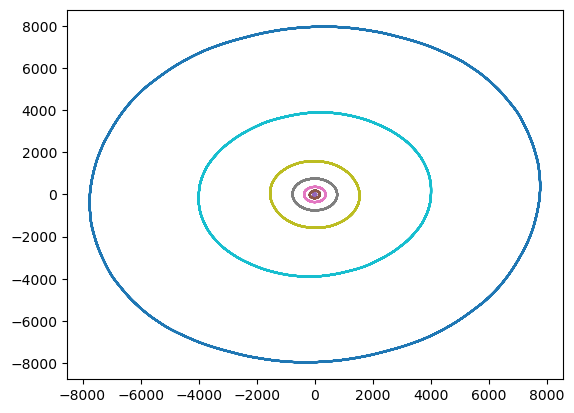

In [26]:
Z_mags = []
D_values = [1, 2, 3, 4, 5, 6, 10, 20, 40, 100, 200]
for D_ in D_values:
    print(D_)
    D_changed = D.copy()
    D_changed[0] = D_
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
    T_sim = 300
    dt = 0.1

    ### --- Estimate C empirically --- ###

    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    x = torch.from_numpy(x).type(torch.FloatTensor).to(0)
    Z = D_changed[0]*np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r.cpu().numpy())
    plt.plot(Z[0,:,0], Z[0,:,1])
    Z_mag = np.sqrt(Z[0,:,0]**2 + Z[0,:,1]**2)
    Z_mags.append(np.amax(Z_mag))

In [29]:
import numpy as np
#import pandas as pd
from numpy.polynomial.hermite import hermgauss
from scipy.special import erf
#from ace_tools import display_dataframe_to_user

# Analytic non-zero mean expression

import numpy as np
from scipy.special import erf, logerf

def erf_bivariate_stable(mu1, mu2, D11, D22, D12):
    """
    High‐precision evaluation of
      E[erf(c*x1)*erf(c*x2)] for a bivariate normal
    with means mu1,mu2 and covariances D11,D22,D12.
    Uses atan2 and works in the log‐domain for the
    exponential factor.
    """
    # c = sqrt(pi)/2
    c2 = np.pi/4    # = c^2
    c = np.sqrt(c2)
    
    A1 = 1 + 2*c2*D11
    A2 = 1 + 2*c2*D22
    B  = 2* c2 * D12
    
    # product of means (no change)
    m1 = erf(c * mu1/np.sqrt(A1))
    m2 = erf(c * mu2/np.sqrt(A2))
    term1 = m1*m2
    
    # exponent in log-domain
    denom = A1*A2 - B*B
    num    = A2*mu1*mu1 - 2*B*mu1*mu2 + A1*mu2*mu2
    logE = - c2 * num/denom
    # clamp logE to avoid -inf
    if logE < -700:    # np.exp(-700) ~ 5e-305
        exp_factor = 0.0
    else:
        exp_factor = np.exp(logE)
    
    # use atan2 for stable arctan
    ar = np.arctan2(B, np.sqrt(denom))
    
    term2 = (2/np.pi) * exp_factor * ar
    return term1 + term2

# Analytic zero-mean expression
def analytic_zero(D11, D22, D12):
    A1 = D11 + 2/np.pi
    A2 = D22 + 2/np.pi
    return (2/np.pi) * np.arcsin(np.clip(D12/np.sqrt(A1*A2), -1, 1))

# Numeric quadrature for non-zero mean
def numeric_nonzero(mu1, mu2, D11, D22, D12, n=300):
    nodes, weights = hermgauss(n)
    z = np.sqrt(2) * nodes
    w = weights / np.sqrt(np.pi)
    W = np.outer(w, w)
    
    Sigma = np.array([[D11, D12],
                      [D12, D22]])
    L = np.linalg.cholesky(Sigma)
    
    Z1, Z2 = np.meshgrid(z, z, indexing='ij')
    X = L[0,0]*Z1 + L[0,1]*Z2 + mu1
    Y = L[1,0]*Z1 + L[1,1]*Z2 + mu2
    
    return np.sum(W * erf((np.sqrt(np.pi)/2)*X) * erf((np.sqrt(np.pi)/2)*Y))

# Test cases
#rng = np.random.RandomState(0)
results = []
# Zero-mean validation
for _ in range(5):
    D11 = rng.uniform(0.5, 2.0)
    D22 = rng.uniform(0.5, 2.0)
    rho = rng.uniform(-0.9, 0.9)
    D12 = rho * np.sqrt(D11 * D22)
    z_analytic = analytic_zero(D11, D22, D12)
    z_numeric = numeric_nonzero(0.0, 0.0, D11, D22, D12)
    results.append(['zero', 0.0, 0.0, D11, D22, D12, z_analytic, z_numeric, z_numeric - z_analytic])

# Non-zero mean validation
for _ in range(5):
    mu1 = rng.uniform(-3, 1)
    mu2 = rng.uniform(-3, 3)
    D11 = rng.uniform(0.5, 2.0)
    D22 = rng.uniform(0.5, 2.0)
    rho = rng.uniform(-0.9, 0.9)
    D12 = rho * np.sqrt(D11 * D22)
    an = erf_bivariate_stable(mu1, mu2, D11, D22, D12)
    num = numeric_nonzero(mu1, mu2, D11, D22, D12)
    results.append(['nonzero', mu1, mu2, D11, D22, D12, an, num, num - an])

# df = pd.DataFrame(results, columns=[
#     'case', 'mu1', 'mu2', 'Delta11', 'Delta22', 'Delta12',
#     'analytic', 'numeric', 'error'
# ])
# display_dataframe_to_user('inner_average_full_validation', df)

ImportError: cannot import name 'logerf' from 'scipy.special' (/home/om2382/.conda/envs/torch-test-3/lib/python3.11/site-packages/scipy/special/__init__.py)

In [28]:
results[-5:]

[['nonzero',
  -2.1043012477584795,
  -0.927889915818584,
  1.8921219401983862,
  1.5566216028852993,
  -1.4462184245191283,
  0.34866366741574445,
  0.2898722453924657,
  -0.05879142202327875],
 ['nonzero',
  -2.341223374008349,
  0.7288704089985814,
  1.3658428829062514,
  0.8568392320617629,
  0.8455248355260414,
  -0.3824759376084719,
  -0.3579596376421405,
  0.024516299966331423],
 ['nonzero',
  -0.5441361761364161,
  0.21379681814975005,
  1.3848649645318565,
  1.5951830442751544,
  -0.5031139704416683,
  -0.17520305113059972,
  -0.1746813746333243,
  0.000521676497275414],
 ['nonzero',
  -1.4071157511356325,
  -1.7409375061492671,
  0.7792895088205043,
  1.9165585849759004,
  0.5269635620540666,
  0.617367753772511,
  0.6097967120437775,
  -0.007571041728733463],
 ['nonzero',
  -1.0381647655297317,
  -1.6355122321600606,
  0.8815347226555894,
  0.5870437404858134,
  -0.08492219405961964,
  0.5083141108904757,
  0.5079363576946037,
  -0.000377753195872077]]

In [30]:
import numpy as np
from scipy.special import erf
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

# ---- Nonlinearity autocorrelation (zero-mean closed form) ----
def compute_C(Delta11, Delta22, Delta12):
    A = (Delta11 + 2/np.pi) * (Delta22 + 2/np.pi)
    in_sqrt = np.clip(A - Delta12**2, 1e-20, None)
    return (2/np.pi) * np.arctan(Delta12 / np.sqrt(in_sqrt))

def compute_C_simple(Delta0, Delta):
    return compute_C(Delta0, Delta0, Delta)

# ---- Average phi' for Gaussian variance var ----
def compute_phi_prime_avg(var):
    return 1/np.sqrt(1 + (np.pi/2)*var)

# ---- Two-point DMFT kernel with oscillatory drive ----
def C_tau(omega, tau, Delta0, Delta, A):
    D0 = Delta0 + A**2
    D  = Delta + A**2 * np.cos(omega*tau)
    return compute_C_simple(D0, D)

# ---- Find self-consistent Delta0 ----
def find_Delta0(g, gamma, alpha, R, omega, A):
    def f(Delta0):
        phi_avg = compute_phi_prime_avg(Delta0 + A**2)
        nu = (g * phi_avg)**2
        leak = 1 - gamma**2 * nu / (alpha * R)
        return leak * Delta0 - g**2 * C_tau(omega, 0.0, Delta0, Delta0, A)
    # bracket search
    a, fa = 1e-6, f(1e-6)
    b, fb = g**2, f(g**2)
    while fa*fb > 0 and b < 1e6:
        b *= 2
        fb = f(b)
    if fa*fb > 0:
        raise RuntimeError("Cannot bracket root for Delta0")
    sol = root_scalar(f, bracket=[a, b], method='bisect', rtol=1e-6)
    return sol.root

# ---- Integrate Δ'' = leak*Δ - g^2 C_tau(t) ----
def integrate_Delta(Delta0, g, gamma, alpha, R, omega, A,
                    tau_max=50.0, N=1001, event=None):
    def ode(t, y):
        Delta, dDelta = y
        phi_avg = compute_phi_prime_avg(Delta0 + A**2)
        nu = (g * phi_avg)**2
        leak = 1 - gamma**2 * nu / (alpha * R)
        ddDelta = leak * Delta - g**2 * C_tau(omega, t, Delta0, Delta, A)
        return [dDelta, ddDelta]
    t_eval = np.linspace(0, tau_max, N)
    sol = solve_ivp(ode, [0, tau_max], [Delta0, 0.0], t_eval=t_eval, rtol=1e-8, event=event)
    return sol.t, sol.y[0]

# ---- Example usage ----
if __name__ == "__main__":
    # parameters
    g, gamma, alpha, R = 5.0, 0.99, 0.5, 2
    omega = 2 * np.pi * 1.0  # 1 Hz
    A = 0.3            # drive amplitude

    # find and integrate
    Delta0 = find_Delta0(g, gamma, alpha, R, omega, A)
    t, Delta = integrate_Delta(d, g, gamma, alpha, R, omega, A)

    print("Delta0 =", Delta0)
    print("Monotonic decrease:", np.all(np.diff(Delta) <= 1e-8))


NameError: name 'd' is not defined

In [7]:
import numpy as np
from numpy.polynomial.hermite import hermgauss
from scipy.special import erf

# Nonlinearity
phi = lambda x: erf((np.sqrt(np.pi)/2)*x)

def analytic_C_phi(tau, A, omega0, Delta_eta0, Delta_eta_tau):
    """
    Analytic expression for C^phi(tau) including noise and signal.
    """
    # ODE filter phase shift
    phi0 = np.arctan(omega0)
    # Signal variance
    sigma_mu2 = (A**2)/(1 + omega0**2)
    # noise constants
    a = 1.0/(Delta_eta0 + 2/np.pi)
    # Prefactor from averaging over m
    prefactor = 2/np.pi / np.sqrt(
        (1 + 2*a*sigma_mu2)**2 - (2*a*sigma_mu2 * np.cos(omega0*tau))**2
    )
    # arcsin term uses noise covariance only
    arg = np.clip(Delta_eta_tau / (Delta_eta0 + 2/np.pi), -1+1e-12, 1-1e-12)
    return prefactor * np.arcsin(arg)

def quadrature_C_phi(tau, A, omega0, Delta_eta0, Delta_eta_tau, n_m=20, n_n=20):
    """
    Gauss-Hermite quadrature over m and noise variables to approximate C^phi(tau).
    """
    # GH for m ~ N(0,1)
    nodes_m, weights_m = hermgauss(n_m)
    m_vals = np.sqrt(2)*nodes_m
    w_m = weights_m/np.sqrt(np.pi)
    Wm = np.outer(w_m, w_m)
    
    # GH for noise u,v ~ correlated N(0, Sigma_eta)
    nodes_n, weights_n = hermgauss(n_n)
    z = np.sqrt(2)*nodes_n
    w_n = weights_n/np.sqrt(np.pi)
    Wn = np.outer(w_n, w_n)
    # Cholesky of noise covariance
    Sigma = np.array([[Delta_eta0, Delta_eta_tau],
                      [Delta_eta_tau, Delta_eta0]])
    L = np.linalg.cholesky(Sigma)
    
    # Prepare arrays
    M1, M2 = np.meshgrid(m_vals, m_vals, indexing='ij')
    Z1, Z2 = np.meshgrid(z, z, indexing='ij')
    
    # Deterministic means mu1, mu2 for t=0 and t=tau
    phi0 = np.arctan(omega0)
    base = A/np.sqrt(1 + omega0**2)
    mu1 = base*(M1*np.cos(-phi0) + M2*np.sin(-phi0))
    mu2 = base*(M1*np.cos(omega0*tau - phi0) +
                M2*np.sin(omega0*tau - phi0))
    
    # Noise contributions
    U = L[0,0]*Z1 + L[0,1]*Z2
    V = L[1,0]*Z1 + L[1,1]*Z2
    
    # Evaluate phi at combined arguments
    PHI1 = phi(mu1[:,:,None,None] + U[None,None,:,:])
    PHI2 = phi(mu2[:,:,None,None] + V[None,None,:,:])
    
    integrand = PHI1 * PHI2
    # Combined weight
    W = Wm[:,:,None,None] * Wn[None,None,:,:]
    return np.sum(W * integrand)

# Test parameters
A = 0.8
omega0 = 1.5
Delta_eta0 = 0.6
# choose a few taus
taus = np.linspace(0, 2.0, 5)

print("tau | analytic     | quadrature    | abs error")
for tau in taus:
    an = analytic_C_phi(tau, A, omega0, Delta_eta0, 0.3)
    quad = quadrature_C_phi(tau, A, omega0, Delta_eta0, 0.3, n_m=16, n_n=16)
    print(f"{tau:4.2f} | {an:12.6f} | {quad:12.6f} | {abs(quad-an):12.6f}")


tau | analytic     | quadrature    | abs error
0.00 |     0.121927 |     0.225355 |     0.103428
0.50 |     0.120209 |     0.200512 |     0.080304
1.00 |     0.118334 |     0.140552 |     0.022218
1.50 |     0.119702 |     0.078491 |     0.041212
2.00 |     0.121852 |     0.046692 |     0.075159


In [8]:
import numpy as np
from numpy.polynomial.hermite import hermgauss
from scipy.special import erf

def compute_C_phi_quadrature(tau, A, Delta0, Delta_tau, theta0, n=40):
    """
    Compute the nonlinearity autocovariance C^phi(tau) via Gauss-Hermite quadrature over m.
    
    Parameters
    ----------
    tau : float
        Time lag.
    A : float
        Amplitude of the filtered sinusoidal drive.
    Delta0 : float
        Noise autocovariance at zero lag, Δ^(η)(0).
    Delta_tau : float
        Noise autocovariance at lag τ, Δ^(η)(τ).
    theta0 : float
        Drive phase angle, where omega0 = tan(theta0).
    n : int, optional
        Number of Gauss-Hermite nodes per dimension (default=40).
    
    Returns
    -------
    C_phi : float
        The value of C^phi(tau).
    """
    # Convert parameters
    omega0 = np.tan(theta0)
    phi0 = np.arctan(omega0)
    base = A / np.sqrt(1 + omega0**2)
    
    # Prepare Gauss-Hermite nodes and weights for m ~ N(0, 1)
    nodes, weights = hermgauss(n)
    m_vals = np.sqrt(2) * nodes
    w = weights / np.sqrt(np.pi)
    W = np.outer(w, w)
    
    # Compute the deterministic means for x^0_m(t) and x^0_m(t+tau)
    M1, M2 = np.meshgrid(m_vals, m_vals, indexing='ij')
    mu1 = base * (M1 * np.cos(-phi0) + M2 * np.sin(-phi0))
    mu2 = base * (M1 * np.cos(omega0 * tau - phi0) + M2 * np.sin(omega0 * tau - phi0))
    
    # Inner closed-form (non-zero mean Gaussian integral)
    A1 = Delta0 + 2/np.pi
    term1 = erf(mu1 / np.sqrt(A1)) * erf(mu2 / np.sqrt(A1))
    term2 = (2/np.pi) * np.exp(-mu1**2 / A1 - mu2**2 / A1) * \
            np.arcsin(np.clip(Delta_tau / A1, -1, 1))
    inner = term1 + term2
    
    # Outer quadrature over m
    C_phi = np.sum(W * inner)
    return C_phi


In [296]:
def C_phi_oscillation(tau, Delta0, Delta_tau, A, theta0):
    """
    Compute the averaged covariance
      C_bar(tau) = E_m[E_z[phi(x1) phi(x2)]]
    for phi(x)=erf(sqrt(pi)/2 * x),
    with heterogenous oscillatory means m1,m2 ~ N(0,1).
    
    Parameters
    ----------
    tau : float or array
        Time lag.
    Delta0 : float
        Baseline variance of the Gaussian fluctuations.
    Delta_tau : float or array
        Covariance of the Gaussian fluctuations at lag tau.
    A : float
        Amplitude of the input drive.
    omega0 : float
        Drive angular frequency.
    
    Returns
    -------
    Cb : float or array
        The averaged covariance C_bar(tau).
    """
    # Effective additional variance from oscillatory means
    omega0 = np.tan(theta0)
    mu = A**2 / (1 + omega0**2)
    
    # Updated variances and covariance
    Delta0p = Delta0 + mu
    Delta_p = Delta_tau + mu * np.cos(omega0 * tau)
    
    # Compute the arctan argument
    numerator = Delta_p
    denom_term = Delta0p + 2/np.pi
    #argument = numerator / np.sqrt(np.clip(denom_term**2 - numerator**2, a_min=None, a_max=None))
    argument = numerator / np.sqrt(denom_term**2 - numerator**2)
    
    # Final result
    Cb = (2/np.pi) * np.arctan(argument)
    
    return Cb

In [406]:
from scipy import optimize

def integrate_Delta(Delta0, g, gamma, alpha, R, D0, theta0,
                    tau_max=50.0, N_t=2001, event=None):
    #solve for A
    omega0 = np.tan(theta0)
    stability_cond = lambda A: 1 - compute_phi_prime_avg(Delta0 + A**2/(1+omega0**2)) * D0 * gamma * np.cos(theta0)
    res = optimize.root_scalar(stability_cond, x0=D0, method='newton')
    A = res.root
    print(res)
    if res.converged is False:
        print(compute_phi_prime_avg(Delta0) * D0 * gamma * np.cos(theta0))
        return 'fail'
    #print(A)
    def ode(t, y):
        Delta, dDelta = y
        phi_prime_avg = compute_phi_prime_avg(Delta0 + A**2/(1+omega0**2))
        nu = (g * phi_prime_avg)**2
        leak = 1 - gamma**2 * nu / (alpha * R)
        ddDelta = leak * Delta - g**2 * C_phi_oscillation(t, Delta0, Delta, A, theta0)
        return [dDelta, ddDelta]
    t_eval = np.linspace(0, tau_max, N_t)
    sol = solve_ivp(ode, [0, tau_max], [Delta0, 0.0], t_eval=t_eval, rtol=1e-8, events=None)
    return sol.t, sol.y[0]

      converged: True
           flag: converged
 function_calls: 12
     iterations: 6
           root: 1.828831590425898
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 3.164062523529898
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.5841745915230003
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.238591443923253
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.4175659217774648
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.5022573114702635
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.543545750746334
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.522985992722325
      converg

/tmp/ipykernel_42737/4011193735.py:38: RuntimeWarning: invalid value encountered in sqrt
  argument = numerator / np.sqrt(denom_term**2 - numerator**2)


      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.515232756520369
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.5165266213850637
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.5171733044176885
      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.516849983671333


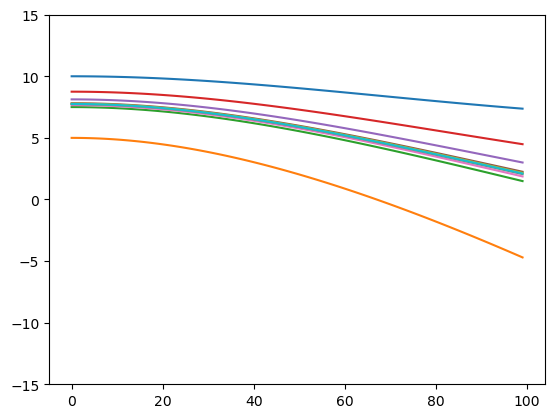

In [407]:
g, gamma, alpha, R = 3.0, 0.99, 0.5, 2
D0 = 5.3
theta0 = np.pi/6
omega0 = np.tan(np.pi/6)  # 1 Hz
d_min = 0
d_max = 20
#A = 4            # drive amplitud
for i_iter in range(1000):
    d = (d_max - d_min)/2 + d_min
    event = lambda t, y: np.abs(np.abs(y[0] - d) + 0.01)
    event.terminal = True
    ret = integrate_Delta(d, g, gamma, alpha, R, D0, theta0, event=event)
    if ret == 'fail':
        d_max = d
    else:
        t, Delta = ret
        if len(np.where(np.logical_or(Delta > d, Delta < -d))[0]) > 0:
            i_cross = sorted(np.where(np.logical_or(Delta > d, Delta < -d))[0])[0]
            if Delta[i_cross] > 0:
                d_max = d
            else:
                d_min = d
            #print(d)
            if i_iter < 10:
                plt.plot(Delta[:100])
                plt.ylim([-15, 15])
        else:
            break
        

In [389]:
gamma * np.cos(theta0) * D0

4.715508323606269

In [390]:
d

7.265625

In [408]:
event = lambda t, y: np.abs(np.abs(y[0] - d) + 0.01)
event.terminal = True
t, Delta = integrate_Delta(d, g, gamma, alpha, R, D0, theta0, event=None)

      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: 2.516849983671333


In [392]:
d

7.265625

In [401]:
omega0 = np.tan(theta0)
stability_cond = lambda A: 1 - compute_phi_prime_avg(d + A**2/(1+omega0**2)) * D0 * gamma * np.cos(theta0)
res = optimize.root_scalar(stability_cond, x0=D0, method='newton')
A = res.root

In [402]:
D0

5.3

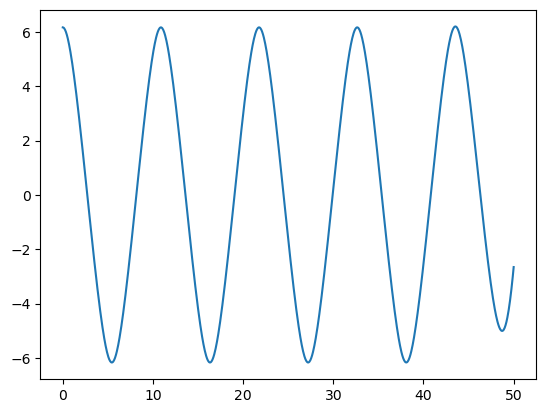

In [371]:
plt.plot(t, Delta)

In [380]:
A**2/(1 + omega0**2)

23.140640244819387

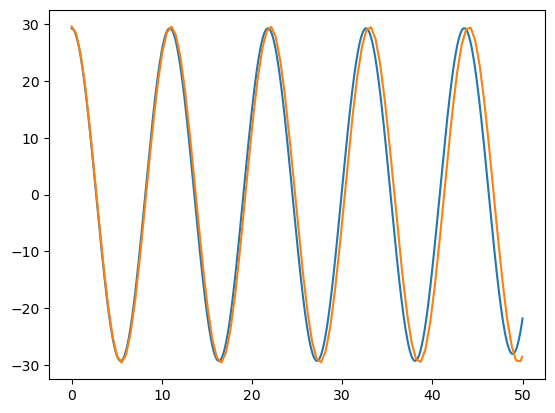

In [374]:
plt.plot(t, Delta + A**2/(1 + omega0**2)*np.cos(omega0 * t))
time_emp = np.arange(0, 50, 0.05)
plt.plot(time_emp, X_emp_avg[:len(time_emp)])

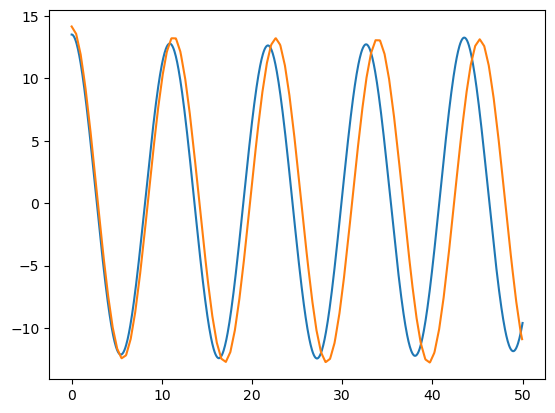

In [396]:
plt.plot(t, Delta + A**2/(1 + omega0**2)*np.cos(omega0 * t))
time_emp = np.arange(0, 50, 0.05)
plt.plot(time_emp, X_emp_avg[:len(time_emp)])

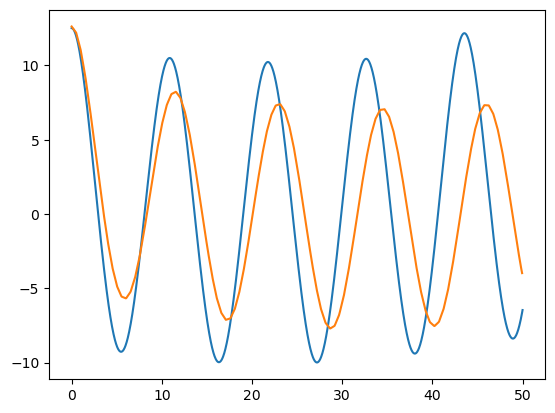

In [414]:

omega0 = np.tan(theta0)
stability_cond = lambda A: 1 - compute_phi_prime_avg(d + A**2/(1+omega0**2)) * D0 * gamma * np.cos(theta0)
res = optimize.root_scalar(stability_cond, x0=D0, method='newton')
A = res.root
plt.plot(t, Delta + A**2/(1 + omega0**2)*np.cos(omega0 * t))
time_emp = np.arange(0, 50, 0.05)
plt.plot(time_emp, X_emp_avg[:len(time_emp)])

In [411]:
d

7.757568359375

In [405]:
(Delta + A**2/(1 + omega0**2)*np.cos(omega0 * t))[0]

12.508468739604792

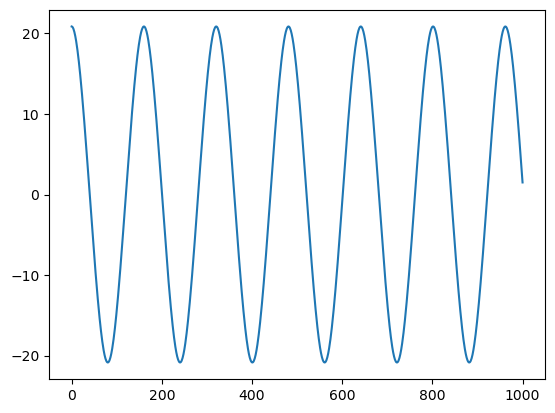

In [116]:
t, Delta = integrate_Delta(20.87, g, gamma, alpha, R, omega, A)
plt.plot(Delta)
#plt.yscale('log')

In [83]:
diff = 1
avg_gains = [0.2]
while diff > 1e-5:
    leak = 1 - gamma**2 * (avg_gains[-1] * g)**2 / (alpha * R)
    if leak < 0:
        avg_gains[-1] *= 0.95
        continue
    d = compute_Delta_0(g=g, leak=leak)
    avg_gain = compute_phi_prime_avg(d)
    avg_gains.append(avg_gain)
    diff = np.abs(avg_gains[-1] - avg_gains[-2])
avg_gain = avg_gains[-1]
leak = 1 - gamma**2 * (avg_gain * g)**2 / (alpha * R)
d = compute_Delta_0(g=g, leak=leak)

In [85]:
d

11.355389339413724

In [50]:
avg_gain = compute_phi_prime_avg(Delta0)
1 - gamma**2 * (avg_gain * g)**2 / (alpha * R)

0.5766456716873121

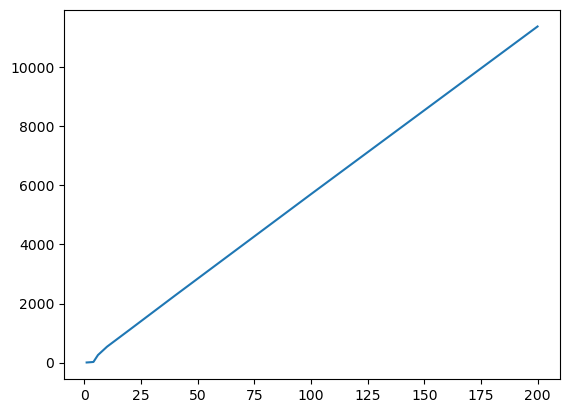

In [14]:
plt.plot(np.array(D_values), Z_mags)

In [6]:
Cs = np.transpose(sigma_mn_all, axes=(2,0,1))
real_freq = gamma * np.cos(np.pi/6)
i_mode = np.argmin(np.abs(np.amax(np.linalg.eigvals(Cs).real, 1) - real_freq))
D_changed = D.copy()
D_changed[i_mode] = 5.5
N_W_samples = 1
C_emp_avg = 0
X_emp_avg = 0
z_ccov_emp_avg = 0

#lags window
dt = 0.1
T_window_emp = 80
dT_emp = 0.5
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

for i_W_sample in range(N_W_samples):
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
    T_sim = 2000
    dt = 0.1
    
    ### --- Estimate C empirically --- ###
    
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    x = torch.from_numpy(x).type(torch.FloatTensor).to(0)
    C_emp_unit = compute_lagged_xcov(r[:,None,:], r[:,None,:], lags_emp, dt_save=dt)
    C_emp = C_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    C_emp = upsample_array(C_emp, int(dT_emp/dt))
    C_emp = np.concatenate([C_emp, np.array([C_emp[-1]]), C_emp[1:][::-1]])
    X_emp_unit = compute_lagged_xcov(x[:,None,:], x[:,None,:], lags_emp, dt_save=dt)
    X_emp = X_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    X_emp = upsample_array(X_emp, int(dT_emp/dt))
    X_emp = np.concatenate([X_emp, np.array([X_emp[-1]]), X_emp[1:][::-1]])
    lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
    
    C_emp_avg += C_emp / N_W_samples
    X_emp_avg += X_emp / N_W_samples
    
    Z = D_changed[i_mode]*np.einsum('air, ti -> atr', all_loadings[i_mode:i_mode+1, :, 2:4], r.cpu().numpy())

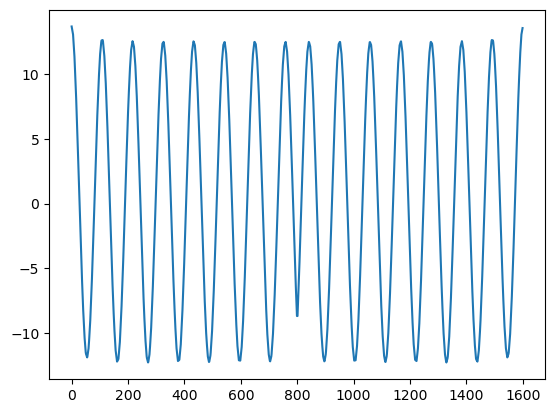

In [38]:
plt.plot(X_emp_avg)

(0.0, 1000.0)

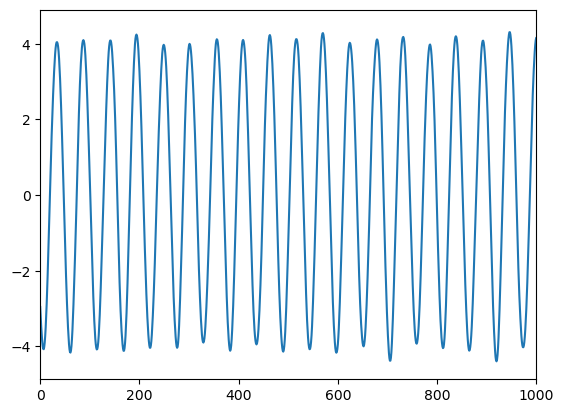

In [36]:
plt.plot(Z[0,:,0] * Z[0,:,1] / N)
plt.xlim([0, 1000])

In [16]:
def integrate_potential(Delta_0, g, leak=1, tau_max=40, N_tau=1000, dT=0.1,
                        driving_term=None):
    def dy_dt(y, t):
        Delta, Delta_dot = y[0], y[1]
        V_deriv = compute_V_deriv(
            Delta_0=Delta_0, Delta=Delta, g=g, leak=leak)
        if driving_term is not None:
            #from pdb import set_trace
            #set_trace()
            t_int = int(np.floor(t/dT))
            y_dot = np.array([Delta_dot, -V_deriv + driving_term[t_int]])
        else:
            y_dot = np.array([Delta_dot, -V_deriv])
        return y_dot
    t_vals = np.arange(0, tau_max, dT)
    out = odeint(dy_dt, y0=np.array([Delta_0, 0.]), t=t_vals, rtol=1e-12)
    Delta = out[:, 0]
    return t_vals, Delta

In [50]:
X_emp_avg[0]

13.661137580871582

In [51]:
avg_gain

0.21101148812338355

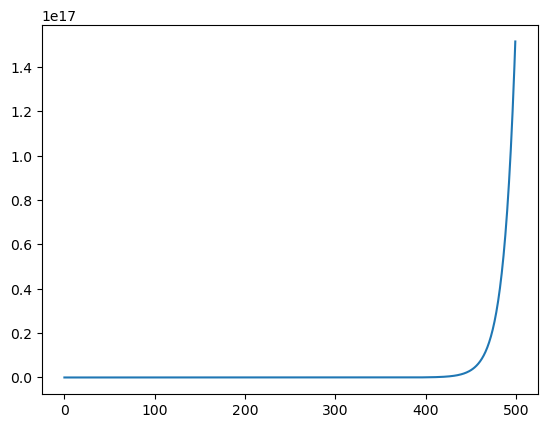

In [57]:
d = X_emp_avg[0]
avg_gain = compute_phi_prime_avg(d)
leak = 1 - gamma**2 * (avg_gain * g)**2 / (alpha * R)
dT = 0.1
T_window = 50
time, Delta_T = integrate_potential(d, g=g, leak=leak, tau_max=T_window, N_tau=int(T_window/dT),
                                    driving_term=4*np.cos(np.tan(np.pi/6) * np.arange(0, T_window, dT)))
#Delta_T = fix(Delta_T)
#C_phi_half_2 = compute_C_simple(d, Delta_T)
plt.plot(Delta_T)

In [15]:
np.cos(np.tan(np.pi/6) * np.arange(0, T_window, dT)).shape

(500,)

In [ ]:
plt.plot(X_emp_avg)

In [ ]:
plt.plot(Z[0,:1000,0])
plt.plot(Z[0,:1000,1])

In [ ]:
import numpy as np
from scipy.special import erf, i0

# Define nonlinearity and its derivative
phi = lambda x: erf((np.sqrt(np.pi)/2) * x)
phi_prime = lambda x: np.exp(-(np.pi/4) * x**2)

# Gaussian integral for C^phi
def compute_C(d11, d22, d12):
    A = (d11 + 2/np.pi) * (d22 + 2/np.pi)
    in_sqrt = np.clip(A - d12**2, 1e-20, None)
    return (2/np.pi) * np.arctan(d12 / np.sqrt(in_sqrt))

# Average gain psi = <phi'>
def compute_psi(delta):
    return np.sqrt(1/((np.pi/2) * delta + 1))

def run_block_haar_dmft(g, alpha=0.5, R=2, 
                        T_total=10.0, dt=0.05,
                        theta=np.pi/3, gamma=0.99,
                        D_condensed=7.0,
                        sigma_nm=None, sigma_mm=None,
                        diag=True, use_correction=True):
    Nt = int(T_total / dt)
    Delta = np.zeros((Nt, Nt))
    Gamma = np.zeros((Nt, Nt))
    Qz    = np.zeros((Nt, Nt))
    kappa = np.zeros((Nt, R))
    H     = np.zeros((Nt, R))
    psi   = np.zeros(Nt)
    G     = np.zeros(Nt)
    diagD = np.zeros(Nt)

    # Bulk latent scale
    D = g / np.sqrt(alpha * R)

    # Overlap for condensed
    if sigma_nm is None:
        sigma_nm = np.array([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta),  np.cos(theta)]])
    Tmat = D_condensed * sigma_nm
    U = D_condensed * np.eye(R)

    print(Tmat)
    # initial conditions
    Delta[0, 0] = 10.0
    diagD[0] = 1.0
    kappa[0,:] = np.array([0, 50])

    for j in range(1, Nt):
        if j % 10 == 0:
            print(j)
        # 1) single-mode
        psi[j] = compute_psi(diagD[j-1])
        G[j]   = G[j-1] + dt * psi[j]
        H[j]   = psi[j] * Tmat.dot(kappa[j-1])
        kappa[j] = (1 - dt) * kappa[j-1] + dt * H[j]

        # 2) Delta
        Delta[:j, j] = (1 - dt) * Delta[:j, j-1] + dt * Gamma[:j, j-1]
        if diag:
            Delta[j, j] = Gamma[j-1, j-1]
        else:
            Delta[j, j] = (1 - dt) * Delta[j, j-1] + dt * Gamma[j, j-1]
        diagD[j] = Delta[j, j]

        # 3) Q^z
        D_s  = diagD[:j+1]
        D_jj = diagD[j]
        D_sj = Delta[:j+1, j]
        base = alpha * R * D**2 * compute_C(D_s, D_jj, D_sj)
        
        for i in range(j+1):
            if not use_correction or i == j:
                Qz[i, j] = base[i]
            else:
                s = np.arange(i+1)
                u = np.arange(j+1)
                ds = (i - s) * dt
                du = (j - u) * dt
                exp_term = np.exp(-ds[:, None] - du[None, :])
                C_su = compute_C(diagD[s][:,None], diagD[u][None,:], Delta[np.ix_(s, u)])
                arg = 2 * D * gamma * np.sqrt((G[i] - G[s])[:,None] * (G[j] - G[u])[None,:])
                bess = i0(arg)
                extra = np.sum(exp_term * C_su * bess)
                extra *= alpha * R * D**2 * (D * gamma)**2 * psi[i] * psi[j] * (dt**2)
                Qz[i, j] = base[i] + extra
            Qz[j, i] = Qz[i, j]

        # 4) Gamma
        A_vals = np.einsum('mn,tm,n->t', U, H[:j], H[j])
        # i=0 separately
        #Gamma[0, j] = dt * (Qz[0, j] + A_vals[0])
        for i in range(j+1):
            Gamma[i, j] = (1 - dt) * Gamma[i-1, j] + dt * Qz[i, j] + dt * A_vals[i-1]

    return {'Delta': Delta, 'Gamma': Gamma, 'Qz': Qz,
            'kappa': kappa, 'H': H, 'psi': psi, 'G': G}

# verify shapes
#out1 = run_block_haar_dmft(3, alpha=0.5, R=2, T_total=20.0, dt=0.1, use_correction=True)
out2 = run_block_haar_dmft(3, alpha=0.5, R=2, T_total=35.0, dt=0.1,
                           D_condensed=6, theta=np.pi/6, use_correction=True)
#print(out1['Qz'].shape, out2['Qz'].shape)


In [ ]:
plt.imshow(out2['Delta'])

In [ ]:
Delta = out2['Delta']
#plt.plot(np.roll(Delta[len(Delta)//2], -len(Delta)//2), label='dmft')
plt.plot(Delta[:,len(Delta)//2])

In [ ]:
plt.plot(out2['psi'][:20])

In [ ]:
import numpy as np
from scipy.special import erf, i0

# Define nonlinearity and its derivative
phi = lambda x: erf((np.sqrt(np.pi)/2) * x)
phi_prime = lambda x: np.exp(-(np.pi/4) * x**2)

# Gaussian integral for C^phi
def compute_C(d11, d22, d12):
    A = (d11 + 2/np.pi) * (d22 + 2/np.pi)
    in_sqrt = np.clip(A - d12**2, 1e-20, None)
    return (2/np.pi) * np.arctan(d12 / np.sqrt(in_sqrt))

# Average gain psi = <phi'>
def compute_psi(delta):
    return np.sqrt(1/((np.pi/2) * delta + 1))

def run_block_haar_dmft(g, alpha=0.5, R=2, 
                        T_total=10.0, dt=0.05, tau=20.0,
                        theta=np.pi/3, gamma=0.99,
                        D_condensed=7.0,
                        sigma_nm=None, sigma_mm=None,
                        diag=True, use_correction=True):
    Nt = int(T_total / dt)
    Delta = np.zeros((Nt, Nt))
    Gamma = np.zeros((Nt, Nt))
    Qz    = np.zeros((Nt, Nt))
    kappa = np.zeros((Nt, R))
    H     = np.zeros((Nt, R))
    psi   = np.zeros(Nt)
    G     = np.zeros(Nt)
    diagD = np.zeros(Nt)

    # Precompute exponential decay lookup for correction window
    decay = np.exp(-np.arange(Nt) * dt)

    # Bulk latent scale
    D = g / np.sqrt(alpha * R)

    # Overlap for condensed
    if sigma_nm is None:
        sigma_nm = np.array([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta),  np.cos(theta)]])
    Tmat = D_condensed * sigma_nm
    U = D_condensed * np.eye(R)

    # initial conditions
    Delta[0, 0] = 1.0
    diagD[0] = 1.0
    kappa[0,:] = np.array([0.1, -0.1])

    for j in range(1, Nt):
        if j % 10 == 0:
            print(j)
        # 1) single-mode
        psi[j] = compute_psi(diagD[j-1])
        if j % 10 == 0:
            print(D * gamma * psi[j])
        G[j]   = G[j-1] + dt * psi[j]
        H[j]   = psi[j] * Tmat.dot(kappa[j-1])
        kappa[j] = (1 - dt) * kappa[j-1] + dt * H[j]

        # 2) Delta
        Delta[:j, j] = (1 - dt) * Delta[:j, j-1] + dt * Gamma[:j, j-1]
        if diag:
            Delta[j, j] = Gamma[j-1, j-1]
        else:
            Delta[j, j] = (1 - dt) * Delta[j, j-1] + dt * Gamma[j, j-1]
        diagD[j] = Delta[j, j]

        # 3) Q^z
        D_s  = diagD[:j+1]
        D_jj = diagD[j]
        D_sj = Delta[:j+1, j]
        base = alpha * R * D**2 * compute_C(D_s, D_jj, D_sj)
        
        start = max(0, j - int(tau/dt))
        for i in range(start, j+1):
            if not use_correction or i == j:
                Qz[i, j] = base[i]
            else:
                # Truncate sums to a moving window of size ~5/psi
                lag_cut = 2.0 / psi[j]
                max_lag = min(j, int(lag_cut / dt))
                s0 = max(0, i - max_lag)
                u0 = max(0, j - max_lag)
                s = np.arange(s0, i+1)
                u = np.arange(u0, j+1)
                # Use precomputed decay lookup instead of exp()
                exp_term = decay[i - s][:, None] * decay[j - u][None, :]
                C_su = compute_C(diagD[s][:,None], diagD[u][None,:], Delta[np.ix_(s, u)])
                arg = 2 * D * gamma * np.sqrt((G[i] - G[s])[:,None] * (G[j] - G[u])[None,:])
                bess = i0(arg)
                extra = np.sum(exp_term * C_su * bess)
                extra *= alpha * R * D**2 * (D * gamma)**2 * psi[i] * psi[j] * (dt**2)
                Qz[i, j] = base[i] + extra
            Qz[j, i] = Qz[i, j]

        # 4) Gamma
        A_vals = np.einsum('mn,tm,n->t', U, H[:j], H[j])
        for i in range(start, j+1):
            prev = Gamma[i-1, j] if i > 0 else 0.0
            Gamma[i, j] = (1 - dt) * prev + dt * Qz[i, j] + dt * A_vals[i-1]

    return {'Delta': Delta, 'Gamma': Gamma, 'Qz': Qz,
            'kappa': kappa, 'H': H, 'psi': psi, 'G': G}

out2 = run_block_haar_dmft(3, alpha=0.5, R=2, T_total=100.0, dt=0.1, tau=40.0,
                           D_condensed=5.05, theta=np.pi/6, use_correction=True)

In [ ]:
import numpy as np
from scipy.special import erf, i0

# Define nonlinearity and its derivative
phi = lambda x: erf((np.sqrt(np.pi)/2) * x)
phi_prime = lambda x: np.exp(-(np.pi/4) * x**2)

# Gaussian integral for C^phi
def compute_C(d11, d22, d12):
    A = (d11 + 2/np.pi) * (d22 + 2/np.pi)
    in_sqrt = np.clip(A - d12**2, 1e-20, None)
    return (2/np.pi) * np.arctan(d12 / np.sqrt(in_sqrt))

# Average gain psi = <phi'>
def compute_psi(delta):
    return np.sqrt(1/((np.pi/2) * delta + 1))

def run_block_haar_dmft(g, alpha=0.5, R=2, 
                        T_total=10.0, dt=0.05, tau=20.0,
                        theta=np.pi/3, gamma=0.99,
                        D_condensed=7.0,
                        sigma_nm=None, sigma_mm=None,
                        diag=True, use_correction=True):
    Nt = int(T_total / dt)
    Delta = np.zeros((Nt, Nt))
    Gamma = np.zeros((Nt, Nt))
    Qz    = np.zeros((Nt, Nt))
    kappa = np.zeros((Nt, R))
    H     = np.zeros((Nt, R))
    psi   = np.zeros(Nt) + 0.0001
    G     = np.zeros(Nt)
    diagD = np.zeros(Nt)

    # Precompute exponential decay lookup for correction window
    decay = np.exp(-np.arange(Nt) * dt)

    # Bulk latent scale
    D = g / np.sqrt(alpha * R)

    # Overlap for condensed
    if sigma_nm is None:
        sigma_nm = np.array([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta),  np.cos(theta)]])
    Tmat = D_condensed * sigma_nm
    U = D_condensed * np.eye(R)

    # initial conditions
    Delta[0, 0] = 1.0
    diagD[0] = 1.0
    kappa[0,:] = np.array([0.1, -0.1])

    for j in range(1, Nt):
        if j % 10 == 0:
            print(j)
        # 1) single-mode
        psi[j] = compute_psi(diagD[j-1])
        if j % 10 == 0:
            print(D * gamma * psi[j])
        G[j]   = G[j-1] + dt * psi[j]
        H[j]   = psi[j] * Tmat.dot(kappa[j-1])
        kappa[j] = (1 - dt) * kappa[j-1] + dt * H[j]

        # 2) Delta
        Delta[:j, j] = (1 - dt) * Delta[:j, j-1] + dt * Gamma[:j, j-1]
        if diag:
            Delta[j, j] = Gamma[j-1, j-1]
        else:
            Delta[j, j] = (1 - dt) * Delta[j, j-1] + dt * Gamma[j, j-1]
        diagD[j] = Delta[j, j]

        # 3) Q^z
        D_s  = diagD[:j+1]
        D_jj = diagD[j]
        D_sj = Delta[:j+1, j]
        base = alpha * R * D**2 * compute_C(D_s, D_jj, D_sj)
        
        start = max(0, j - int(tau/dt))
        for i in range(start, j+1):
            if not use_correction or i == j:
                Qz[i, j] = base[i]
            else:
                # 1) split windows for s and u based on their own ψ
                lag_cut_s = 5.0 / psi[i]
                lag_cut_u = 5.0 / psi[j]
                max_lag_s = min(i, int(lag_cut_s / dt))
                max_lag_u = min(j, int(lag_cut_u / dt))
                s0 = i - max_lag_s
                u0 = j - max_lag_u
                s = np.arange(s0, i+1)
                u = np.arange(u0, j+1)
                # 2) use decay lookup
                exp_term = decay[i - s][:, None] * decay[j - u][None, :]
                C_su = compute_C(diagD[s][:,None], diagD[u][None,:], Delta[np.ix_(s, u)])
                arg = 2 * D * gamma * np.sqrt((G[i] - G[s])[:,None] * (G[j] - G[u])[None,:])
                bess = i0(arg)
                extra = np.sum(exp_term * C_su * bess)
                extra *= alpha * R * D**2 * (D * gamma)**2 * psi[i] * psi[j] * (dt**2)
                Qz[i, j] = base[i] + extra
            Qz[j, i] = Qz[i, j]
        for i in range(0, start):
            Qz[i, j] = base[i]
            Qz[j, i] = Qz[i, j]

        # 4) Gamma
        A_vals = np.einsum('mn,tm,n->t', U, H[:j], H[j])
        for i in range(0, j+1):
            prev = Gamma[i-1, j] if i > 0 else 0.0
            Gamma[i, j] = (1 - dt) * prev + dt * Qz[i, j] + dt * A_vals[i-1]

    return {'Delta': Delta, 'Gamma': Gamma, 'Qz': Qz,
            'kappa': kappa, 'H': H, 'psi': psi, 'G': G}

out2 = run_block_haar_dmft(3, alpha=0.5, R=2, T_total=30.0, dt=0.1, tau=30.0,
                           D_condensed=0, theta=np.pi/6, use_correction=True)


In [ ]:
diff = 1
avg_gains = [0.2]
while diff > 1e-5:
    leak = 1 - gamma**2 * (avg_gains[-1] * g)**2 / (alpha * R)
    if leak < 0:
        avg_gains[-1] *= 0.95
        continue
    d = compute_Delta_0(g=g, leak=leak)
    avg_gain = compute_phi_prime_avg(d)
    avg_gains.append(avg_gain)
    diff = np.abs(avg_gains[-1] - avg_gains[-2])
avg_gain = avg_gains[-1]
leak = 1 - gamma**2 * (avg_gain * g)**2 / (alpha * R)
d = compute_Delta_0(g=g, leak=leak)
dT = 0.1
T_window = 15
time, Delta_T = integrate_potential(d, g=g, leak=leak, tau_max=T_window, N_tau=int(T_window/dT))
Delta_T = fix(Delta_T)
C_phi_half_2 = compute_C_simple(d, Delta_T)
plt.plot(Delta_T)

In [ ]:
diff = 1
avg_gains = [0.2]
while diff > 1e-5:
    leak = 1 - gamma**2 * (avg_gains[-1] * g)**2 / (alpha * R)
    if leak < 0:
        avg_gains[-1] *= 0.95
        continue
    d = compute_Delta_0(g=g, leak=leak)
    avg_gain = compute_phi_prime_avg(d)
    avg_gains.append(avg_gain)
    diff = np.abs(avg_gains[-1] - avg_gains[-2])
avg_gain = avg_gains[-1]
D_crit_omega = 1/(avg_gain * gamma * np.cos(np.pi/6))

In [ ]:
d = compute_Delta_0(g=g, leak=1)
avg_gain = compute_phi_prime_avg(d)
D_crit_omega = 1/(avg_gain * gamma * np.cos(np.pi/6))

In [ ]:
D_crit_omega

In [ ]:
np.tan(np.pi/6)

In [ ]:
plt.imshow(out2['Delta'])

In [ ]:
plt.plot(out2['kappa'])

In [ ]:
Delta = out2['Delta']
#plt.plot(np.roll(Delta[len(Delta)//2], -len(Delta)//2), label='dmft')
plt.plot(Delta[:,len(Delta)//2])
plt.plot(Delta_T)


In [ ]:
Delta = out['Delta']
plt.plot(np.roll(Delta[len(Delta)//2], -len(Delta)//2), label='dmft')
#plt.axhline(y=np.amax(np.roll(Delta[len(Delta)//2], -len(Delta)//2)))

In [ ]:
Cs = np.transpose(sigma_mn_all, axes=(2,0,1))
real_freq = gamma * np.cos(np.arctan(params['freq']))
i_mode = np.argmin(np.abs(np.amax(np.linalg.eigvals(Cs).real, 1) - real_freq))

In [ ]:
eigs = np.linalg.eigvals(sigma_mn_all[:,:,i_mode])
max_eig = eigs[np.argmax(eigs.real)]
omega_special = max_eig.imag/max_eig.real
diff = 1
avg_gains = [0.2]
while diff > 1e-5:
    leak = 1 - gamma**2 * (avg_gains[-1] * g)**2 / (alpha * R)
    if leak < 0:
        avg_gains[-1] *= 0.95
        continue
    d = compute_Delta_0(g=g, leak=leak)
    avg_gain = compute_phi_prime_avg(d)
    avg_gains.append(avg_gain)
    diff = np.abs(avg_gains[-1] - avg_gains[-2])
avg_gain = avg_gains[-1]
D_crit_omega = 1/(avg_gain * gamma * np.cos(np.arctan(omega_special)))
D_changed = D.copy()
D_changed[i_mode] = params['D_crit_factor'] * D_crit_omega

In [ ]:
N_W_samples = 1
C_emp_avg = 0
S_emp_avg = 0
z_ccov_emp_avg = 0

#lags window
dt = 0.05
T_window_emp = 80
dT_emp = 0.5
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

for i_W_sample in range(N_W_samples):
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
    T_sim = 2000
    dt = 0.05
    
    ### --- Estimate C empirically --- ###
    
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    x = torch.from_numpy(x).type(torch.FloatTensor).to(0)
    C_emp_unit = compute_lagged_xcov(r[:,None,:], r[:,None,:], lags_emp, dt_save=dt)
    C_emp = C_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    C_emp = upsample_array(C_emp, int(dT_emp/dt))
    C_emp = np.concatenate([C_emp, np.array([C_emp[-1]]), C_emp[1:][::-1]])
    X_emp_unit = compute_lagged_xcov(x[:,None,:], x[:,None,:], lags_emp, dt_save=dt)
    X_emp = X_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    X_emp = upsample_array(X_emp, int(dT_emp/dt))
    X_emp = np.concatenate([X_emp, np.array([X_emp[-1]]), X_emp[1:][::-1]])
    lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
    
    C_emp_avg += C_emp / N_W_samples
    X_emp_avg += X_emp / N_W_samples

In [ ]:
processed_data = np.array([X_emp_avg, C_emp_avg])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'clean_haar_bifurcation'
job_name = 'frequency_dependent_check'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='misc')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='misc', lkumar=True)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
!ls -t ../job_scripts/

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'rotation_dominant'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='misc')

In [ ]:
theory_results[0]

In [ ]:
i_alpha = 0
i_g = 2
i_N = 1
i_sigma_off = 2
i_seed = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
# ax[0].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 0, :200])
# ax[0].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 1, :200])
# ax[1].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 2, :2400])
# ax[1].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 3, :2400])
dt = 0.05
time_1 = np.arange(0, 10, dt)
time_2 = np.arange(0, 60, dt)
ax[0].plot(time_1, theory_results[1][i_sigma_off, i_seed, 1, :200], color='#E69629')
#ax[0].plot(time_1, theory_results[1][i_sigma_off, i_seed, 0, :200], color='k', linestyle='--')
ax[0].legend(['sim'])#, 'theory'])
ax[1].plot(time_2, theory_results[1][i_sigma_off, i_seed, 3, :1200], color='#E69629')
#ax[1].plot(time_2, theory_results[1][i_sigma_off, i_seed, 2, :1200], color='k', linestyle='--')
ax[0].set_title(r'$S^\phi(\tau)$')
ax[1].set_title(r'$C^\phi(\tau)$')
ax[0].set_xlabel(r'$\tau$')
ax[1].set_xlabel(r'$\tau$')
ax[0].set_yticks([0, 0.075, 0.15])
ax[1].set_yticks([0, 0.4, 0.8])
plt.tight_layout()
fig.savefig('figs/S_C_no_theory_fit.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 0, :])
ax[0].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 1, :])
ax[1].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 2, :])
ax[1].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 3, :])

In [ ]:
i_sigma_off = 2
#network properties size
#N = theory_results[0]['N'][i_N]
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 5
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][i_sigma_off, i_seed, 0, :], dtype=torch.float32).to(0)
C = torch.tensor(theory_results[1][i_sigma_off, i_seed, 2, :], dtype=torch.float32).to(0)
N_t = C.shape[0]
#T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)
C_w = uni_rfft(C, dt)

In [ ]:
### --- bifurcation analysis --- ###
sigma_mn_all = np.zeros((R, R, N_tasks))
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task] = generate_positive_definite_covariance(R=R, sigma_on=0.5,
                                                                     sigma_off=1.5,
                                                                     symmetry_factor=-1)
sigma_mn_all[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
Crr = sigma_mn_all[:,:,0]
SA = np.max(np.real(D[0]*np.linalg.eigvals(Crr) * S_.cpu().numpy()[0]*(np.sqrt(2*np.pi))))

In [ ]:
SA

In [ ]:
T_sim = 50
dt = 0.05
xs = []
rs = []
x0 = None
Ds = np.arange(1/SA - 0.2, 1/SA + 1, 0.1)
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N, seed=0)
for D_factor in Ds:

    D_changed = D.copy()
    D_changed[0] = D[0] * D_factor

    # Multiply loadings_m by D
    D_tensor = torch.from_numpy(D_changed.astype(np.float32)).to(0)  # (N_tasks,)
    loadings = torch.from_numpy(all_loadings.astype(np.float32)).to(0)
    loadings_m = loadings[:, :, :R]  # (N_tasks, N, R)
    loadings_n = loadings[:, :, R:]  # (N_tasks, N, R)
    D_expanded = D_tensor[:, None, None]  # (N_tasks, 1, 1)
    loadings_m_weighted = D_expanded * loadings_m  # (N_tasks, N, R)

    # Reshape loadings_m_weighted and loadings_n to (N, N_tasks * R)
    loadings_m_weighted_flat = loadings_m_weighted.permute(1, 0, 2).reshape(N, -1)  # (N, N_tasks * R)
    loadings_n_flat = loadings_n.permute(1, 0, 2).reshape(N, -1)  # (N, N_tasks * R)

    # Compute W = loadings_m_weighted_flat @ loadings_n_flat.T
    W_ = loadings_m_weighted_flat @ loadings_n_flat.T  # (N, N)
    
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=True, T_save_delay=0, noise_series=None)
    x0 = torch.tensor(x[-1]).to(torch.float).to(0)[None,:]
    xs.append(x)
    rs.append(r)
x = np.concatenate(xs, axis=0)
r = np.concatenate(rs, axis=0)
Z_hat = np.einsum('air, ti -> atr', all_loadings[:6, :, 2:4], r)
plt.figure(figsize=(10, 2))
plt.plot(Z_hat[0,:,0])
plt.plot(Z_hat[0,:,1])
for i in range(len(Ds) + 1):
    plt.axvline(x=i*int(T_sim/dt), color='k', linestyle='--')
plt.figure(figsize=(10, 2))
plt.plot(Z_hat[1,:,0])
plt.plot(Z_hat[1,:,1])
for i in range(len(Ds) + 1):
    plt.axvline(x=i*int(T_sim/dt), color='k', linestyle='--')
plt.figure(figsize=(10, 2))
plt.plot(x[:,0])
plt.plot(x[:,2])
for i in range(len(Ds) + 1):
    plt.axvline(x=i*int(T_sim/dt), color='k', linestyle='--')

In [ ]:
np.savez('multi_task_elife/packaged_results/bifurcation_traces.npz', x=x[:,:10], r=r[:,:10], Z_hat=Z_hat, Dfs=Ds)

In [ ]:
!du -sh multi_task_elife/packaged_results/bifurcation_traces.npz

In [ ]:
Crr = np.array([[0.8, -0.4],[0.4, 0.8]])
#Crr = Crr
#Crr = Crr.T
#T = len(C_phi)
#t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
#sampfreq = 1/dT
#w = 2*np.pi*sampfreq*t_indices/T
S_omega = np.sqrt(2*np.pi)*S_.cpu().numpy()[:,None,None]
M_inv = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr[None,:,:]*S_omega)
M_invT = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr.T[None,:,:]*S_omega.conj())
z_ccov = np.zeros_like(M_inv)
for w in range(z_ccov.shape[0]):
    z_ccov[w] = D[0]**2 * M_inv[w,:,:].dot(M_invT[w,:,:]) * C_w[w].cpu().numpy()
z_ccov_w = torch.from_numpy(z_ccov).to(0)
z_ccov_T = uni_irfft(z_ccov_w, 0.05, axis=0)
#z_ccov_T = z_ccov_T.cpu().numpy()

In [ ]:
z_ccov_avg = theory_results[1][i_sigma_off, i_seed, :, :].T
T = z_ccov_T.shape[0]

i_task = 0
acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])

In [ ]:
acov_T_11.shape

In [ ]:
fig, ax = plt.subplots(2, 2)
time_vec = np.arange(-len(acov_avg_11)*dt/2, len(acov_avg_11)*dt/2, dt)
ax[0,0].plot(time_vec, acov_avg_11, color='#AC85BC')
#ax[0,0].plot(time_vec, acov_T_11, color='k', linestyle='--')
ax[1,1].plot(time_vec, acov_avg_22, color='#AC85BC')
#ax[1,1].plot(time_vec, acov_T_22, color='k', linestyle='--')
ax[0,1].plot(time_vec, ccov_avg_21, color='#AC85BC')
#ax[0,1].plot(time_vec, ccov_T_12, color='k', linestyle='--')
ax[1,0].plot(time_vec, ccov_avg_12, color='#AC85BC')
#ax[1,0].plot(time_vec, ccov_T_21, color='k', linestyle='--')
ax[0,0].set_title(r'$C^z_{11}(\tau)$')
ax[0,1].set_title(r'$C^z_{12}(\tau)$')
ax[1,0].set_title(r'$C^z_{21}(\tau)$')
ax[1,1].set_title(r'$C^z_{22}(\tau)$')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$')
        ax[i,j].set_xlim([-50, 50])
ax[0,0].legend(['sim'])#, 'theory'])
plt.tight_layout()
fig.savefig('figs/cross_cov_no_theory_fits.pdf')

In [ ]:
np.amax(ccov_T_12)/np.amax(ccov_avg_21)

In [ ]:
np.amax(acov_T_11)/np.amax(acov_avg_11)

In [ ]:
plt.plot(smoothed_S.cpu())
plt.plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 1, :])

In [ ]:
job_name = 'LDR_sym_PR_match_rho_sim_final_5'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
plt.ion()

def_colors = X = plt.rcParams['axes.prop_cycle'].by_key()["color"]

plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1.5
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.minor.width'] = 0.4
plt.rcParams['figure.dpi'] = 225
plt.rcParams['figure.figsize'] = [7.5/2.54, 5/2.54]
plt.rcParams['path.simplify'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.formatter.limits'] = (-3,3)

In [ ]:
theory_results[0]

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
for i in range(3):
    for j in range(5):
        for i_seed in range(3):
            ax[i,j].plot(theory_results[1][i,j,i_seed,2,:800], color='C0')
            ax[i,j].plot(theory_results[1][i,j,i_seed,3,:800], color='C1')
            ax[i,j].set_ylim([0, 1])

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
for i in range(3):
    for j in range(5):
        for i_seed in range(3):
            ax[i,j].plot(theory_results[1][i,j,i_seed,0,:800], color='C0')
            ax[i,j].plot(theory_results[1][i,j,i_seed,1,:800], color='C1')
            ax[i,j].set_ylim([0, 1])

In [ ]:
### --- Intensive rank task --- ###

N = 5000
R = 2
N_tasks = 1
g = 2
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
Crr = np.array([[0.8, -0.4], [0.4, 0.8]])

W_, all_loadings = sample_W_optimized(Crr[:,:,None], D, N)
x0 = 0.5*all_loadings[0,:,2] + 0.5*all_loadings[0,:,3]
x1, r1 = sample_activity(T_sim=30, dt_save=0.01, dt=0.01, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=30*torch.from_numpy(x0[None,:]).to(0))
x2, r2 = sample_activity(T_sim=30, dt_save=0.01, dt=0.01, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=1300*torch.from_numpy(x0[None,:]).to(0))

Z1 = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r1) * D[:1,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r2) * D[:1,None,None]

z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
#fig = plt.figure(figsize=(5, 5))
plt.plot([Z1[0, 0, 0]], [Z1[0, 0, 1]], marker='o', ms=3, markerfacecolor='none', color=z_color)
plt.plot(Z1[0,:2500, 0], Z1[0,:2500, 1], color=z_color)
plt.plot([Z2[0, 0, 0]], [Z2[0, 0, 1]], marker='o', ms=3, markerfacecolor='none', color=z_color)
plt.plot(Z2[0,:2500, 0], Z2[0,:2500, 1], color=z_color)

skip = 100  # interval to place arrows
length = 20
x, y = Z1[0,:2500,0], Z1[0,:2500,1]
arrow_spots = [2, 3, 10, 100, 300, 500, 700]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*1000, vy*1000, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=8, headlength=8, headaxislength=8)
x, y = Z2[0,:2500,0], Z2[0,:2500,1]
for i in [10]:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*1000, vy*1000, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=8, headlength=8, headaxislength=8)
plt.xticks([-5000, 0, 5000], ['-N', '0', 'N'])
plt.yticks([-5000, 0, 5000], ['-N', '0', 'N'])
#fig.savefig('cosyne24_figs/intensive_rank_ex.pdf', dpi=300)

In [ ]:
### --- Extensive number of tasks --- ###

smn_all = theory_results[3]['0.8_8_0']
#smn_all_changed = smn_all.copy()
#smn_all_changed[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.1 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed, N)
x1, r1 = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=10)
#I_current = 100*torch.from_numpy(0.5*all_loadings_changed[0,:,0] + 0.5*all_loadings_changed[0,:,1]).to(0)
x2, r2 = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0),
                        input_current=None)
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z1 = np.einsum('air, ti -> atr', all_loadings[:5, :, 2:4], r1) * D[:5,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]

z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 120
T_steps_show = int(T_show/0.05)
plt.plot(Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*5, vy*5, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xticks([-25, 0, 25])
plt.yticks([-25, 0, 25])

In [ ]:
fig.savefig('cosyne24_figs/extensive_rank_ex.pdf', dpi=300)

In [ ]:
### --- DMFT Example --- ###

D2Cphi = D[0]**2 * C
C_rr = torch.tensor(smn_all[:,:,0], dtype=torch.float32).to(0)
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, 0.05)
N_trials = 1
N_t = S.shape[0]
Z_sim_trials = np.zeros((N_trials, 2, N_t))
sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
for i_trial in range(N_trials):
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[0], C_rr=C_rr, kernel=S).cpu().numpy()
    Z_sim_trials[i_trial] = Z_sim
z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 120
T_steps_show = int(T_show/0.05)
plt.plot(Z_sim_trials[0, 0, :T_steps_show], Z_sim_trials[0, 1, :T_steps_show], color=z_color, linestyle='--')
skip = 50  # interval to place arrows
x, y = Z_sim_trials[0, 0, :T_steps_show], Z_sim_trials[0, 1, :T_steps_show]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*5, vy*5, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.xticks([-25, 0, 25])
plt.yticks([-25, 0, 25])
fig.savefig('cosyne24_figs/extensive_rank_dmft_ex.pdf', dpi=300)

In [ ]:
### --- Compare autocovs of theory and simulation --- ###\

smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.1 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
x1, r1 = sample_activity(T_sim=15000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z1 = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r1) * D[:9,None,None]
z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z1[:,:,:], axis=1, norm='ortho'))**2, axis=1)

D2Cphi = D[0]**2 * C

N_t_extra = int(T_extra/dt)
half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
N_t_total = len(D2Cphi_extended)

C_rr = torch.tensor(smn_all[:,:,0], dtype=torch.float32).to(0)
N_trials = 20
N_t = S.shape[0]
Z_sim_trials_task = np.zeros((10, N_trials, 2, N_t_total))
for i_task in range(9):
    print(i_task)
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    D2Cphi = D[i_task]**2 * C
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    N_t_total = len(D2Cphi_extended)
    Z_sim_trials = np.zeros((N_trials, 2, N_t_total))
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[i_task], C_rr=C_rr, kernel=smoothed_S[:1000]).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    Z_sim_trials_task[i_task] = Z_sim_trials
z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials_task[:,:,:,:], axis=3, norm='ortho'))**2, axis=3).mean(1)

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'cosyne_sim_results_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results_2 = unpack_processed_data(job_script_path, results_subdir='misc')

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))

In [ ]:
S_ = uni_rfft(S, 0.05)
S_[1000:] = 0
plt.plot(uni_irfft(S_, 0.05).cpu())

In [ ]:
SR

In [ ]:
np.amax(uni_rfft(D2Cphi, 0.05).cpu().numpy().imag)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
ax = ax.flatten()
z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials_task[:,:,:,:], axis=3, norm='ortho'))**2, axis=3).mean(1)
for i_task in range(9):
    ax[i_task].plot(z_acov[i_task,:800,0], color='C0')
    ax[i_task].plot(z_acov[i_task,:800,1], color='C1')
    ax[i_task].plot(z_sim_acov[i_task,0,:800], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov[i_task,1,:800], color='C1', linestyle='--')

In [ ]:
plt.plot(z_acov[:800,0])
plt.plot(z_acov[:800,1])
plt.plot(z_sim_acov.T[:800,0], color='C0', linestyle='--')
plt.plot(z_sim_acov.T[:800,1], color='C1', linestyle='--')

In [ ]:
### --- Phase transition --- ###

smn_all = theory_results[3]['0.8_8_0']
#smn_all_changed = smn_all.copy()
#smn_all_changed[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed_1 = D.copy()
D_factor_1 = 0.9 / SR
D_changed_1[0] *= D_factor_1
D_changed_2 = D.copy()
D_factor_2 = 1.1 / SR
D_changed_2[0] *= D_factor_2
D_changed_3 = D.copy()
D_factor_3 = 1.3 / SR
D_changed_3[0] *= D_factor_3

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
W_changed_1, all_loadings_changed_1 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_1, N)
W_changed_2, all_loadings_changed_2 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_2, N)
W_changed_3, all_loadings_changed_3 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_3, N)
x, r = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=10)
x1, r1 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_1, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x[-1][None,:]).to(0))
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_2, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0))
x3, r3 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_3, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x2[-1][None,:]).to(0))
X = np.vstack([x, x1, x2, x3])
R = np.vstack([r, r1, r2, r3])

Z = np.einsum('air, ti -> atr', all_loadings[:4, :, 2:4], r) * D[:4,None,None]
Z1 = np.einsum('air, ti -> atr', all_loadings_changed_1[:4, :, 2:4], r1) * D_changed_1[:4,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings_changed_2[:4, :, 2:4], r2) * D_changed_2[:4,None,None]
Z3 = np.einsum('air, ti -> atr', all_loadings_changed_3[:4, :, 2:4], r3) * D_changed_3[:4,None,None]

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(4.5*0.7, 0.7))
fig.tight_layout()
ax[0].plot(Z[0,:6000,0], Z[0,:6000,1], color=z_color)
ax[1].plot(Z1[0,:6000,0], Z1[0,:6000,1], color=z_color)
ax[2].plot(Z2[0,:6000,0], Z2[0,:6000,1], color=z_color)
ax[3].plot(Z3[0,:6000,0], Z3[0,:6000,1], color=z_color)
ax[0].set_xlim([-40, 40])
ax[0].set_ylim([-40, 40])
ax[0].set_xticks([-40, 40])
ax[0].set_yticks([-40, 40])
ax[1].set_xlim([-100, 100])
ax[1].set_ylim([-100, 100])
ax[2].set_xlim([-200, 200])
ax[2].set_ylim([-200, 200])
ax[3].set_xlim([-600, 600])
ax[3].set_ylim([-600, 600])
ax[3].set_xticks([-600, 600])
ax[3].set_yticks([-600, 600])
fig.savefig('cosyne24_figs/escalating_DCS_z1_2.pdf')

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 75
T_steps_show = int(T_show/0.05)
plt.plot(Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*10, vy*10, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xticks([-50, 0, 50])
plt.yticks([-50, 0, 50])
#fig.savefig('cosyne24_figs/extensive_rank_ex.pdf', dpi=300)

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 180
T_steps_show = int(T_show/0.05)
plt.plot(Z2[0,:T_steps_show,0], Z2[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z2[0,:T_steps_show,0], Z2[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*10, vy*10, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)

In [ ]:
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])

In [ ]:
plt.plot(theory_results[1][2,9,0,0,:200])
plt.plot(theory_results[1][2,9,0,1,:200])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
#i_seed = 2
for i in range(5):
    for j in range(10):
        for i_seed in range(5):
            ax[i,j].plot(theory_results[1][i,j,i_seed,0,:200], color='C0', linewidth=2)
            ax[i,j].plot(theory_results[1][i,j,i_seed,1,:200], color='C1')
            #ax[i,j].plot(theory_results[1][i,j,0,0,:600], color='C0')
            #ax[i,j].plot(theory_results[1][i,j,0,1,:600], color='C1')
            ax[i,j].set_ylim([0, 0.5])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
for i in range(5):
    for j in range(10):
        for i_seed in range(5):
            ax[i,j].plot(theory_results[1][i,j,i_seed,2,:800], color='C0', linewidth=2)
            ax[i,j].plot(theory_results[1][i,j,i_seed,3,:800], color='C1')
            ax[i,j].set_ylim([-0.1, 1.1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
smn_all_changed = smn_all.copy()
smn_all_changed[:,:,0] = np.array([[0.4, -0.2], [0.2, 0.4]])
S = torch.tensor(theory_results[1][2,9,2,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,2,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all_changed[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 0.5 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all_changed, D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all_changed, D_changed, N)
x1, r1 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200)
#I_current = 100*torch.from_numpy(0.5*all_loadings_changed[0,:,0] + 0.5*all_loadings_changed[0,:,1]).to(0)
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0),
                        input_current=None)
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])

In [ ]:
r_acov = np.fft.irfft(np.abs(np.fft.rfft(r2, axis=0, norm='ortho'))**2, axis=0).mean(1)

In [ ]:
plt.plot(Z_changed[0,:,0])

In [ ]:
plt.plot(r_acov[:2000])

In [ ]:
r2_ss = r2[::20,:]

In [ ]:
r2_cov = np.einsum('ti, tj -> ij', r2_ss, r2_ss)/(r2_ss.shape[0] - 1)

In [ ]:
eigs, vecs = np.linalg.eig(r2_cov)

In [ ]:
proj = r2[2000:23000].dot(vecs[:,:4])
plt.plot(proj[:,0], proj[:,1])

In [ ]:
proj_m = r2[6000:23000].dot(np.linalg.pinv(all_loadings_changed[0,:,:2].T))
proj_m_2 = r2[6000:23000].dot(all_loadings_changed[0,:,:2])
plt.plot(proj_m[:,0], proj_m[:,1])
plt.plot(proj_m_2[:,0], proj_m_2[:,1])

In [ ]:
Ms = all_loadings_changed[0,:,:2].T

In [ ]:
PCs = vecs[:,:2]

In [ ]:
pc_m_proj = Ms.dot(PCs)/(np.sqrt(np.sum(Ms**2, 1))[:,None])

In [ ]:
# Function to project vector 'a' onto vector 'b'
def project(a, b):
    return np.dot(b.T, a) / np.dot(b.T, b) * b

# Orthogonalize the first set against the second set
def orthogonalize(vectors, basis):
    # Iterate over each vector in 'vectors' and subtract projection onto 'basis'
    orthogonal_vectors = np.zeros_like(vectors)
    for i in range(vectors.shape[1]):
        projection = np.zeros_like(vectors[:, i])
        for j in range(basis.shape[1]):
            projection += project(vectors[:, i], basis[:, j])
        orthogonal_vectors[:, i] = vectors[:, i] - projection
    return orthogonal_vectors

# Compute the orthogonal components of v relative to w
v_orthogonal = orthogonalize(PCs, Ms.T)

# Output the resulting orthogonal vectors
print(v_orthogonal)


In [ ]:
v_orth_unit = v_orthogonal / np.sqrt(np.sum(v_orthogonal**2, 0))[None, :]

In [ ]:
v_orth_unit

In [ ]:
eigs_W, vecs_W = np.linalg.eig(W_changed.cpu().numpy())

In [ ]:
proj_strength = np.square(np.abs(v_orth_unit.T.dot(vecs_W[:,:])).sum(0))
plt.scatter(eigs_W.real, eigs_W.imag, alpha=np.sqrt(proj_strength/np.max(proj_strength)))

In [ ]:
# do mean field theory with replacing g^2 C term with stuff from mutually referential self consistent picture
# figure out mechanism for boosting tasks? can be subtle, phase transition

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 20000:22000,1])

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 22000:23000,1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
smn_all_changed = smn_all.copy()
smn_all_changed[:,:,0] = np.array([[0.4, -0.2], [0.2, 0.4]])
S = torch.tensor(theory_results[1][2,9,2,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,2,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 1000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all_changed[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.5 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all_changed[:,:,:N_tasks], D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all_changed[:,:,:N_tasks], D_changed, N)
x1, r1 = sample_activity(T_sim=500, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200)
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0))
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r) * D_changed[:5,None,None]

In [ ]:
plt.plot(Z_changed[0,:,0])

In [ ]:
plt.plot(Z_changed[0,:,0])
plt.plot(Z_changed_small_M[0,:,0])

In [ ]:
np.amax(Z_changed[0,:,0])/np.amax(Z_changed_small_M[0,:,0])

In [ ]:
_**2

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 20000:21000,0])

In [ ]:
plt.plot(x[1000:3000,0])

In [ ]:
plt.plot(phi_prime_numpy(x).mean(-1)[20000:21000])
plt.plot(phi_prime_numpy(x).mean(-1)[:1000])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * C
    #N_t_extra = int(T_extra/dt)
    #half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    #half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    #D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 10
    #N_t_total = D2Cphi_extended.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
[np.linalg.eigvals(smn_all[:,:,i_task]) for i_task in range(4)]

In [ ]:
D[0]

In [ ]:
SRs = [0.4, 0.405, 0.41, 0.415]
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax = ax.flatten()
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
    D_changed[0] *= D_factor
    D2Cphi = D_changed[i_task]**2 * C
    T_extra = 2000
    dt = 0.05
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
    ax[i_SR].plot(Z_sim[0], Z_sim[1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
S = torch.tensor(theory_results[1][2,9,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,0,2,:], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
#W_, all_loadings = sample_W_optimized(smn_all, D, N)
#x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
#                       runga_kutta=True, T_save_delay=100)
#Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D[i_task]**2 * C
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
smn_all = theory_results[3]['0.5_1_1.4_0']
S = torch.tensor(theory_results[1][1,1,3,0,0], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,1,3,0,1], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 1
g = 1.4
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D_changed = D.copy()
D_factor = 0.5 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
D_changed[0] *= D_factor
W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)
x, r = sample_activity(T_sim=12000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * C
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 80
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
#is it really the noise stability thing like chat gpt thinks or
#am i just not normalizing the fourier transform correctly?

In [ ]:
D_factor = 0.5 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(torch.fft.rfft(S).cpu().numpy())[0])))

In [ ]:
np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.real(torch.fft.fft(S).cpu().numpy())[0])))

In [ ]:
smn_all = theory_results[3]['0.5_1_1.4_0']
S = torch.tensor(theory_results[1][1,1,3,0,0], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,1,3,0,1], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 1
g = 1.4
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D_changed = D.copy()
D_factor = 0.3 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
D_changed[0] *= D_factor
i_task = 0
W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)

In [ ]:
plt.plot(torch.abs(uni_rfft(S, 0.05).cpu()))

In [ ]:
torch.fft.rfft(S)

In [ ]:
plt.plot(torch.real(torch.fft.rfft(S).cpu()))

In [ ]:
x, r = sample_activity(T_sim=12000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z = np.einsum('air, ti -> atr', all_loadings[:5, :, 2:4], r) * D_changed[:5,None,None]

In [ ]:
D2Cphi = D_changed[i_task]**2 * C
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
N_trials = 1
N_t = S.shape[0]
Z_sim_trials = np.zeros((N_trials, 2, N_t))
i_trial = 0
sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
plt.plot(Z_sim[0], Z_sim[1])

In [ ]:
plt.plot(D2Cphi.cpu())
T_extra = 1000
dt = 0.05
N_t_extra = int(T_extra/dt)

half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
plt.plot(D2Cphi_extended.cpu())

In [ ]:
SRs = [0.4, 0.405, 0.41, 0.415]
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax = ax.flatten()
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
    D_changed[0] *= D_factor
    D2Cphi = D_changed[i_task]**2 * C
    T_extra = 2000
    dt = 0.05
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
    ax[i_SR].plot(Z_sim[0], Z_sim[1])

In [ ]:
np.abs(np.linalg.eigvals(D_changed[0]*smn_all[:,:,0]*torch.fft.rfft(S).cpu().numpy()[0]))

In [ ]:
np.abs(np.linalg.eigvals(D_changed[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt

In [ ]:
torch.fft.rfft(S, norm='backward')[0].cpu().numpy()

In [ ]:
np.linalg.eigvals(D_changed[0] * smn_all[:,:,0]) * S_w_max

In [ ]:
S_w_max

In [ ]:
SRs = [0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1]
fig, ax = plt.subplots(len(SRs), figsize=(2, 14))
S_w_max = np.abs(torch.fft.rfft(S, norm='backward').cpu().numpy())[0] * dt
original_SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*S_w_max)))
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / original_SR
    D_changed[0] *= D_factor
    i_task = 0
    W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)
    eigs = np.linalg.eigvals(W_.cpu().numpy())
    ax[i_SR].plot(eigs.real, eigs.imag, '.')

In [ ]:
for error in [-0.2, 0.1, 0.05, 0.05, 0.1, 0.2]:
    print(np.linalg.eigvals((D_changed[0] + error)*smn_all[:,:,0]*uni_rfft(S, 0.05).cpu().numpy()[0]))

In [ ]:
eigs = np.linalg.eigvals(W_.cpu().numpy())
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
np.linalg.eigvals(D_changed[0]*smn_all[:,:,0] * np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])

In [ ]:
D[0]**2 * C[0]

In [ ]:
np.amax(np.abs(D_changed[0]*np.linalg.eigvals(smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))

In [ ]:
plt.plot(C.cpu().numpy())

In [ ]:
plt.plot(np.abs(uni_rfft(S, 0.05).cpu().numpy()))

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(8, 10))
for i in range(5):
    for j in range(3):
        ax[i,j].plot(theory_results[1][i,j,0,0,1,:600], color='C0')
        ax[i,j].plot(theory_results[1][i,j,0,0,2,:600], color='C1')
        ax[i,j].set_ylim([0, 1])

In [ ]:
smn_all = theory_results[3]['0.5_6_False_0']


In [ ]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)
#Network size
R = 2
sigma_sigma = 0.5
N_tasks = 5000
alpha = N_tasks / N
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
def sample_W(sigma_mn_all, D, N):
    W = 0
    R = sigma_mn_all.shape[0]
    N_tasks = sigma_mn_all.shape[2]
    all_loadings = np.zeros((N_tasks, N, 2*R))
    for i_task in range(N_tasks):
        sigma_mm = np.eye(R)
        sigma_nn = np.eye(R)
        sigma_mn = sigma_mn_all[:,:,i_task]
        covariance_top = np.hstack([sigma_mm, sigma_mn])
        covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
        covariance = (1/N)*np.vstack([covariance_top, covariance_bot])

        loadings = np.random.multivariate_normal(np.zeros(2*R), covariance, size=N)
        all_loadings[i_task] = loadings
        W_task = D[i_task]*np.einsum('ir, jr -> ij', loadings[:,:R], loadings[:,R:])
        W += W_task
    W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
    
    return W_, all_loadings

#W_, all_loadings = sample_W(smn_all*N, D, N)

In [ ]:


D_changed = D.copy()
D_changed[0] *= 3
W_, all_loadings = sample_W_optimized(smn_all*N, D_changed, N)

In [ ]:
W_ = torch.from_numpy(W_).to(0)

In [ ]:
eigs, vecs = np.linalg.eig(W_.cpu().numpy())

In [ ]:
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=1000)

In [ ]:
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]

In [ ]:
S_ft = uni_rfft(S, dt=0.05)

In [ ]:
M_omega = D[0]*C_rr.cpu().numpy()[:,:,None]*(S_ft.cpu().numpy()[None,None,:])

In [ ]:
np.abs(np.linalg.eig(D[0]*C_rr.cpu().numpy() * S_ft.cpu().numpy()[0])[0])

In [ ]:
plt.plot(torch.abs(S_ft.cpu()))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * torch.tensor(theory_results[1][4,1,0,0,1], dtype=torch.float32).to(0)
    S = torch.tensor(theory_results[1][4,1,0,0,0], dtype=torch.float32).to(0)
    C_rr = N*torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
plt.plot(D2Cphi.cpu())
plt.plot(z_acov[:,0])

In [ ]:
plt.plot(sim_eta_z.cpu()[0], sim_eta_z.cpu()[1])

In [ ]:
plt.plot(Z[i_task,:4800,0], Z[i_task,:4800,1])
plt.plot(Z_sim[0], Z_sim[1])

In [ ]:
S = torch.tensor(theory_results[1][4,1,0,0], dtype=torch.float32).to(0)
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
Z_sim = run_z_dynamics(sim_eta_z, dt=0.1, d=D[0], C_rr=C_rr, kernel=S)

In [ ]:
Z_sim.shape

In [ ]:
ccw_scores = []
fig, ax = plt.subplots(3, 5, figsize=(6, 4))
ax = ax.flatten()
for i_task in range(15): 
    x = Z[i_task,:100,0]
    y = Z[i_task,:100,1]
    ax[i_task].plot(x, y)
    skip = 50  # interval to place arrows
    length = 10
    for i in range(0, len(x) - skip, skip):
        ax[i_task].arrow(x[i], y[i], length*(x[i + 1] - x[i]), length*(y[i + 1] - y[i]),
                  shape='full', lw=2, length_includes_head=False, head_width=3)
    

In [ ]:
fig, ax = plt.subplots(3, 9, figsize=(20, 6))
for i in range(0, 27, 3):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        ax[j,i//3].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[j,i//3].set_ylim([-0.5, 0.5])
        ax[j,i//3].set_xlim([-1, 150])
    ax[0,i//3].set_title('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(27, 3, figsize=(12, 38))
for i in range(0, 27, 1):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        #ax[i,j].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[i,j].plot(R/R[1])
        ax[i,j].set_ylim([-1.2, 1.2])
        ax[i,j].set_xlim([-1, 150])
        ax[0,j].set_title('u shift = {}'.format(theory_results[0]['t_shift'][j]))
    ax[i,0].set_ylabel('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(9, 3, figsize=(5, 15))
for i in range(27):
    ax[i%9, i//9].plot(np.squeeze(theory_results[1])[i,0])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6.8, 2))
cols = ['#CCB966', '#EA696A', '#336E96']
for i in range(3):
    for j in range(3):
        s = sim_results[1][:,i,j,:,0].mean(1)
        ax[i].plot(sim_results[0]['rho_1'], s, '.', color=cols[j])
        t = theory_results[1][:,i,j,0,1]
        sing_unit_fit = theory_results[1][:,i,j,0,2]
        #c_fit = theory_results[1][:,i,j,0,2]
        ax[i].plot(theory_results[0]['rho_1'], t, color=cols[j])
        ax[i].plot(theory_results[0]['rho_1'], sing_unit_fit, color='k')
        #ax[i].plot(theory_results[0]['rho_1'], c_fit, color='k')
    ax[i].set_ylim([0, 0.07])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(5):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,2], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_1$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
sim_results[0]
fig, ax = plt.subplots(5, 1, figsize=(2, 10))
for i in range(5):
    ax[i].plot(sim_results[0]['rho_max'], sim_results[1][:,i,:,0].mean(-1), '.')
    ax[i].set_ylim([0, 0.1])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_max'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_max'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_max'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{max}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_offset'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{offset}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')


In [ ]:
plt.hist(np.log10(theory_results[1][:,:,:,2].flatten()))

In [ ]:
plt.figure(figsize=(4, 4))
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,1], color='k')
plt.xticks([-0.8, 0, 0.8])
plt.xlabel('$rho$')
plt.ylabel('PR')
plt.ylim([0, 0.1])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    lags = results_array[i,0,0]
    for k in range(10):
        ax[i].plot(lags, results_array[i,k,1], color='C0', alpha=0.3)
    ax[i].plot(lags, np.roll(results_array[i,k,2], -1), color='C1')
    ax[i].plot(lags, results_array[i,:,1].mean(0), color='C0')

In [ ]:
results_array.shape

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
i_g = 1
for i in range(2):
    for j in range(2):
        lags = results_array[0,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i_g,i,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i_g,i,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i_g,i,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i_g],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))
        ax[i,j].set_xlim([-30, 30])
#fig.savefig('figs/LDR_sym_psi_fit_g={}_zoom.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(9, 15))
for i in range(4):
    for j in range(2):
        lags = results_array[i//2,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i//2,i%2,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i//2,i%2,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i//2,i%2,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i//2],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])

In [ ]:
sem_pr.confidence_interval.low

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
i_alpha = 1
i_G = 1
mean_pr = results_array[:,i_alpha,i_G,:,0].mean(-1)
sem_pr = results_array[:,i_alpha,i_G,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,i_alpha,i_G,0,1], color='k')
ax[0].set_ylim([0, 0.1])

In [ ]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
#fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])